<a href="https://colab.research.google.com/github/m3llad0/TC3007C/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from zipfile import ZipFile
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization , MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow

In [3]:
#Download the dataset from kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

with ZipFile('chest-ctscan-images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

!rm chest-ctscan-images.zip


 99% 117M/119M [00:06<00:00, 24.9MB/s]
100% 119M/119M [00:06<00:00, 19.4MB/s]


## Preprocesamiento de datos



In [5]:
train_data_dir = './Data/train'
test_data_dir = './Data/test'
validation_data_dir = './Data/valid'

In [6]:
input_size = (224, 224)

training_datagen = ImageDataGenerator(dtype='float32',)
test_datagen = ImageDataGenerator( dtype='float32')
validation_datagen = ImageDataGenerator( dtype='float32')

# Load and preprocess training data
train_generator = training_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

# Load and preprocess testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

# Load and preprocess validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


## Construcción del modelo

El modelo se construyó utilizando como base


In [7]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(include_top=False,
                      pooling='avg',
                      weights='imagenet',
                      input_shape = (224, 224, 3))

for layer in base_model.layers:
  if 'conv5' not in layer.name:
    layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [8]:
model = tensorflow.keras.models.Sequential()
num_classes = len(train_generator.class_indices)

model.add(base_model)
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(verbose = 1,
                               patience = 5,
                               restore_best_weights = True)
epochs = 100
history = model.fit(
    train_generator,
    verbose = 1,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])



Epoch 1/100
20/20 [==============================] - 31s 494ms/step - loss: 0.9843 - accuracy: 0.7145 - val_loss: 255.4571 - val_accuracy: 0.1806
Epoch 2/100
20/20 [==============================] - 6s 298ms/step - loss: 0.2637 - accuracy: 0.9217 - val_loss: 44.0822 - val_accuracy: 0.1806
Epoch 3/100
20/20 [==============================] - 8s 384ms/step - loss: 0.1198 - accuracy: 0.9576 - val_loss: 10.8254 - val_accuracy: 0.4722
Epoch 4/100
20/20 [==============================] - 7s 339ms/step - loss: 0.1076 - accuracy: 0.9576 - val_loss: 1.8570 - val_accuracy: 0.7917
Epoch 5/100
20/20 [==============================] - 7s 329ms/step - loss: 0.0581 - accuracy: 0.9804 - val_loss: 1.2562 - val_accuracy: 0.7917
Epoch 6/100
20/20 [==============================] - 6s 298ms/step - loss: 0.0793 - accuracy: 0.9837 - val_loss: 1.0586 - val_accuracy: 0.7778
Epoch 7/100
20/20 [==============================] - 7s 335ms/step - loss: 0.0741 - accuracy: 0.9821 - val_loss: 2.2636 - val_accuracy: 0

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                        

In [12]:
model.evaluate(test_generator)

10/10 [==============================] - 5s 514ms/step - loss: 0.9884 - accuracy: 0.7778


[0.9883617758750916, 0.7777777910232544]

Text(0.5, 1.0, 'Training and Validation Accuracy over Epochs')

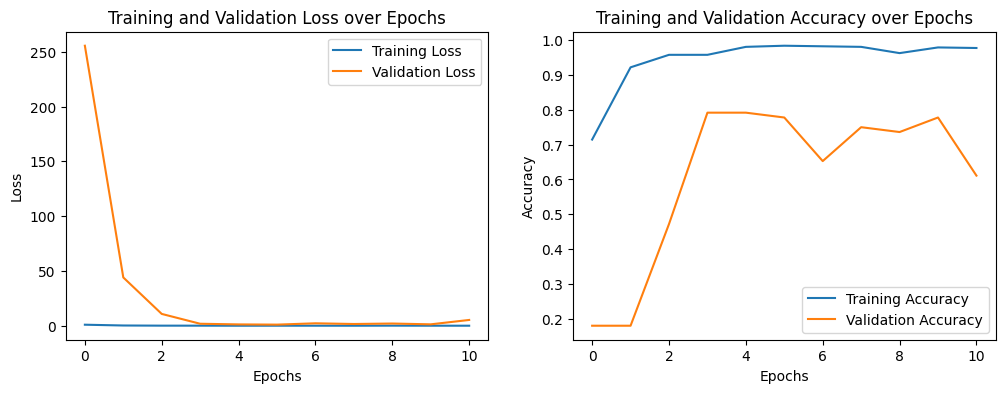

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')

10/10 [==============================] - 4s 301ms/step


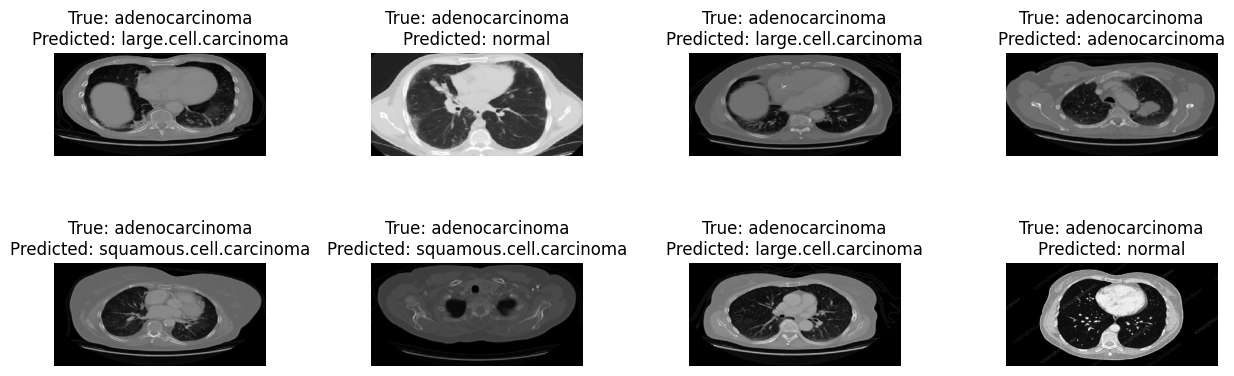

In [14]:
sample_images, _ = next(test_generator)

# Generar predicciones en el conjunto de datos de prueba
predictions = model.predict(test_generator)

# Obtener las etiquetas reales y predichas
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

class_labels = list(test_generator.class_indices.keys())

# Mostrar las imágenes con etiquetas reales y predichas
plt.figure(figsize=(15, 10))
for i in range(8):  # Muestra las primeras 16 imágenes
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i]/255)
    plt.title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
    plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Ajusta el espacio vertical y horizontal entre subgráficos


[[36 25 31 28]
 [16  7 17 11]
 [11  8 19 16]
 [33 13 20 24]]


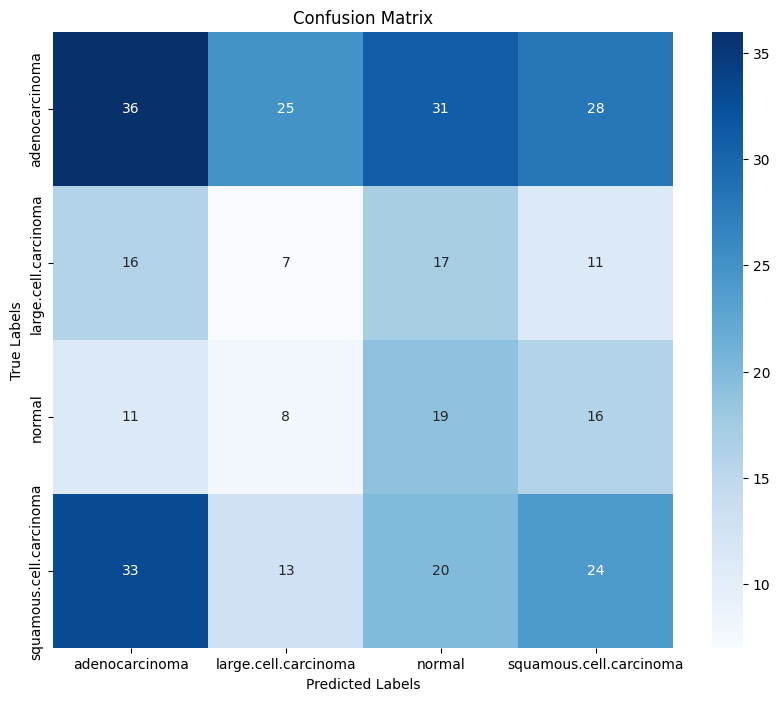

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Obtener etiquetas de clases para visualización
class_labels = list(test_generator.class_indices.keys())

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Ajuste de modelo

In [64]:
base_model_ = ResNet50(include_top=False,
                      pooling='avg',
                      weights='imagenet',
                      input_shape = (224, 224, 3))

for layer in base_model.layers:
  layer.trainable = False
  # if 'conv5' not in layer.name:

In [90]:
model_ajusted = tensorflow.keras.models.Sequential()
num_classes = len(train_generator.class_indices)

model_ajusted.add(base_model_)
model_ajusted.add(Dropout(0.5))
model_ajusted.add(Flatten())
model_ajusted.add(BatchNormalization())
model_ajusted.add(Dropout(0.5))
model_ajusted.add(Dense(num_classes, activation='softmax'))

In [91]:
model_ajusted.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.000001),
              metrics=['accuracy'])

In [92]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor = 'val_loss',
                              verbose = 1,
                               patience = 2,)


checkpoint = ModelCheckpoint(filepath='./transfer_model.hdf5',
                               monitor='val_loss',
                               verbose = 1,
                               save_best_only=True)
epochs = 100
history_ajusted = model_ajusted.fit(
    train_generator,
    verbose = 1,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint])



Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 2.6477 - accuracy: 0.2121
Epoch 1: val_loss improved from inf to 1.49906, saving model to ./transfer_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 62s 2s/step - loss: 2.6477 - accuracy: 0.2121 - val_loss: 1.4991 - val_accuracy: 0.1667
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 2.5865 - accuracy: 0.2104
Epoch 2: val_loss improved from 1.49906 to 1.41129, saving model to ./transfer_model.hdf5
20/20 [==============================] - 25s 1s/step - loss: 2.5865 - accuracy: 0.2104 - val_loss: 1.4113 - val_accuracy: 0.2361
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 2.5289 - accuracy: 0.2349
Epoch 3: val_loss improved from 1.41129 to 1.33370, saving model to ./transfer_model.hdf5
20/20 [==============================] - 20s 985ms/step - loss: 2.5289 - accuracy: 0.2349 - val_loss: 1.3337 - val_accuracy: 0.2639
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 2.3693 - accuracy: 0.2447
Epoch 4: val_loss improved from 1.33370 to 1.24997, saving model to ./transfer_model.hdf5
20/20 [==============================] - 25s 1s/step - 

In [93]:
model_ajusted.evaluate(test_generator)

10/10 [==============================] - 3s 281ms/step - loss: 0.3632 - accuracy: 0.9048


[0.3632248342037201, 0.9047619104385376]

Text(0.5, 1.0, 'Training and Validation Accuracy over Epochs')

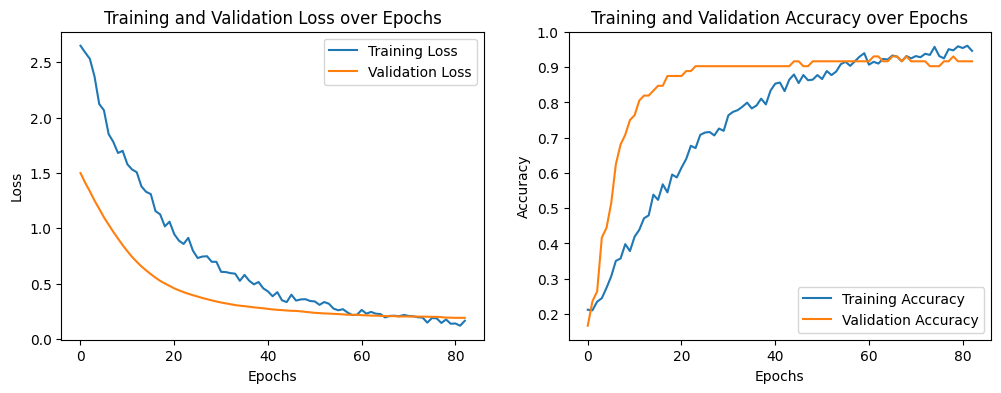

In [94]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ajusted.history['loss'], label='Training Loss')
plt.plot(history_ajusted.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_ajusted.history['accuracy'], label='Training Accuracy')
plt.plot(history_ajusted.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')

10/10 [==============================] - 5s 362ms/step


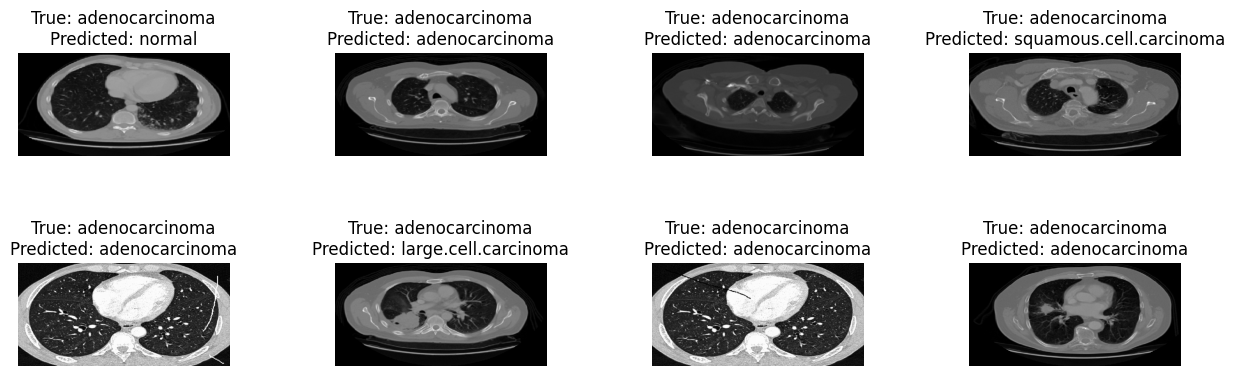

In [95]:
sample_images, _ = next(test_generator)

# Generar predicciones en el conjunto de datos de prueba
predictions = model_ajusted.predict(test_generator)

# Obtener las etiquetas reales y predichas
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

class_labels = list(test_generator.class_indices.keys())

# Mostrar las imágenes con etiquetas reales y predichas
plt.figure(figsize=(15, 10))
for i in range(8):  # Muestra las primeras 16 imágenes
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i]/255)
    plt.title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
    plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Ajusta el espacio vertical y horizontal entre subgráficos


[[38 26 19 37]
 [22  5  9 15]
 [14 11  8 21]
 [20 15 17 38]]


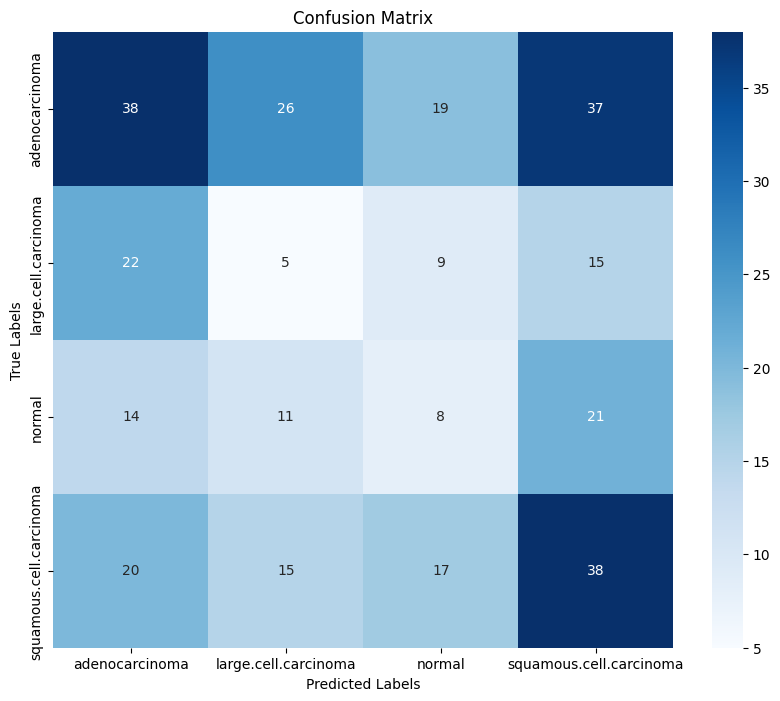

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Obtener etiquetas de clases para visualización
class_labels = list(test_generator.class_indices.keys())

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()